In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-family: JetBrains Mono;
</style>

In [2]:
# Suggested imports. Do not use import any modules that are not in the requirements.txt file on the VLE.

import sklearn.metrics
import sklearn.model_selection
import matplotlib.pyplot as plt
import random
import collections
import torch
import pandas as pd
import numpy as np
%matplotlib inline


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# Movie titles assignment

Table of contents:

* [Data filtering and splitting (10%)](#Data-filtering-and-splitting-(10%))
* [Title classification (25%)](#Title-classification-(25%))
* [Title generation (25%)](#Title-generation-(25%))
* [Language models as classifiers (30%)](#Language-models-as-classifiers-(30%))
* [Conclusion (10%)](#Conclusion-(10%))

Information:

This assignment is 100% of your assessment.
You are to follow the instructions below and fill each cell as instructed.
Once ready, submit this notebook on VLE with all the outputs included (run all your code and don't clear any output cells).
Do not submit anything else apart from the notebook and do not use any extra data apart from what is requested.

## Introduction

A big shot Hollywood producer is looking for a way to automatically generate new movie titles for future movies and you have been employed to do this (in exchange for millions of dollars!).
A data set of movie details has already been collected from IMDb for you and your task is to create the model and the algorithms necessary to use it.

## Data filtering and splitting (10%)

Start by downloading the CSV file `filmtv_movies - ENG.csv` from [this kaggle data set](https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset).

The CSV file needs to be filtered as the producer is only interested in certain types of movie titles.
Load the file and filter it so that only movies with the following criteria are kept:

* The country needs to be `United States` (and no other country should be mentioned).
* The genre should be `Action`, `Horror`, `Fantasy`, `Western`, and `Adventure`.
* The title should not have more than 20 characters.

In [3]:
df = pd.read_csv('data.csv')  #Load full csv

In [4]:
df = pd.read_csv('data.csv')  #Load full csv
df = df[df['country'] == 'United States'] #Country == United States
df = df[df['genre'].isin(['Action','Horror','Fantasy','Western','Adventure'])] #Filter genre
df = df[df['title'].str.len() < 21] # Title does not have more than 20 characters
df['title'] = df['title'].apply(lambda s: s.lower()) #Set all titles to lowercase
df = df[['title','genre']] # Only title and genre columns are needed


df = df.sample(frac=1) #Shuffle dataset
df.to_csv('filtered_data.csv', index=False)
df

,title,genre
3486,the magic of lassie,Adventure
20606,1408,Horror
8189,song of the south,Adventure
33007,it comes at night,Horror
19463,eddie macon's run,Action
...,...,...
23284,the lawless range,Western
37567,the forever purge,Horror
2286,empire strikes back,Fantasy
5881,nomads,Horror


Split the filtered data into 80% train, 10% validation, and 10% test.
You will only need the title and genre columns.

In [5]:
#df = pd.read_csv('filtered_data.csv')

#Train = 80%, Other = 20%
train_x, other_x, train_y, other_y = sklearn.model_selection.train_test_split(df['title'],df['genre'],
                                                             test_size=0.2, random_state=1)


#Split other in half -> [Train = 80%, Val = 10%, Test = 10%]
val_x, test_x, val_y, test_y = sklearn.model_selection.train_test_split(other_x, other_y,
                                                       test_size=0.5, random_state=1)



From your processed data set, display:

* the amount of movies in each genre and split
* 5 examples of movie titles from each genre and split

In [6]:
print('Amount of Movies in Training Set:')
print(train_y.value_counts())

print('\nAmount of Movies in Validation Set:')
print(val_y.value_counts())

print('\nAmount of Movies in Testing Set:')
print(test_y.value_counts())

Amount of Movies in Training Set:
Action       722
Horror       644
Fantasy      434
Western      428
Adventure    371
Name: genre, dtype: int64

Amount of Movies in Validation Set:
Horror       80
Action       79
Fantasy      67
Adventure    51
Western      48
Name: genre, dtype: int64

Amount of Movies in Testing Set:
Horror       94
Action       87
Western      61
Adventure    42
Fantasy      41
Name: genre, dtype: int64


In [17]:
train = pd.DataFrame(columns=['title'], data=train_x)
train['genre'] = train_y

val = pd.DataFrame(columns=['title'], data=val_x)
val['genre'] = val_y

test = pd.DataFrame(columns=['title'], data=test_x)
test['genre'] = test_y

for genre in cat2idx.keys():  
    print(f'5 Random {genre} movies from each split:')
    
    print(f"Train:{list(train[train['genre']==genre]['title'].sample(n=5).apply(lambda s: ''.join(s)))}\n")
    print(f"Validate:{list(val[val['genre']==genre]['title'].sample(n=5).apply(lambda s: ''.join(s)))}\n")    
    print(f"Test:{list(test[test['genre']==genre]['title'].sample(n=5).apply(lambda s: ''.join(s)))}\n")
    
    print('\n\n=================================\n')
    

5 Random Action movies from each split:
Train:['47 ronin', 'ring of fire ii', 'vanish', 'volcano', 'jarhead 3: the siege']

Validate:['snitch', 'out for a kill', 'lethal weapon', 'armstrong', 'thursday']

Test:['double take', 'el mariachi', 'death wish', 'jolt', 'fast & furious']




5 Random Horror movies from each split:
Train:['the roommate', 'constantine', 'hidden', 'pet sematary', 'the exorcist']

Validate:['alligator people', 'tales of terror', 'the maze', 'species ii', 'robocroc']

Test:['the cell 2', 'evil never dies', 'dead birds', 'c.h.u.d.', 'diary of the dead ']




5 Random Fantasy movies from each split:
Train:['invisible man', 'dracula untold', 'the abyss', 'outlander', 'rainbow']

Validate:['casper', 'time freak', 'the satan bug', 'age of dinosaurs', 'legion']

Test:['g-force ', 'eve of destruction', '3022', 'prince charming', 'transcendence']




5 Random Western movies from each split:
Train:['jubilee trail', 'apache drums', 'three hours to kill', 'shenandoah', 'sprin

## Title classification (25%)

Your first task is to prove that a neural network can identify the genre of a movie based on its title.

You will note that many titles are just a single word or two words long so you need to work at the character level instead of the word level, that is, a token would be a single character, including punctuation marks and spaces.
You must also lowercase the titles.
Preprocess the data sets, create a neural network, and train it to classify the movie titles into their genre.
Plot a graph of the **accuracy** of the model on the train and validation sets after each epoch.

In [11]:
# Tokenise each character.
train_x = train_x.apply(lambda s: [*s])
val_x = val_x.apply(lambda s: [*s])
test_x = test_x.apply(lambda s: [*s])

# Get the lengths of each title.
train_lens_x = torch.tensor([len(title) for title in train_x],
                            dtype=torch.int64, device=device)
val_lens_x = torch.tensor([len(title) for title in val_x],
                          dtype=torch.int64, device=device)
test_lens_x = torch.tensor([len(title) for title in test_x],
                           dtype=torch.int64, device=device)

# Get the maximum length of a title.
train_max_len = max(train_lens_x)
val_max_len = max(val_lens_x)
test_max_len = max(test_lens_x)

# Create the vocabulary.
vocab = ['<PAD>'] + \
    sorted({token for sent in pd.concat(
        [train_x, val_x, test_x]) for token in sent})

# Pad the titles to max_len characters using <PAD> tokens.
padded_train_x = [sent + ['<PAD>'] *
                  (train_max_len - len(sent)) for sent in train_x]
padded_val_x = [sent + ['<PAD>']*(val_max_len - len(sent)) for sent in val_x]
padded_test_x = [sent + ['<PAD>'] *
                 (test_max_len - len(sent)) for sent in test_x]

# Replace each character with its index in the vocabulary.
indexed_train_x = torch.tensor([[vocab.index(token) for token in title]
                               for title in padded_train_x],
                               dtype=torch.int64, device=device)
indexed_val_x = torch.tensor([[vocab.index(token) for token in title]
                              for title in padded_val_x],
                             dtype=torch.int64, device=device)
indexed_test_x = torch.tensor([[vocab.index(token) for token in title]
                               for title in padded_test_x],
                              dtype=torch.int64, device=device)


categories = ['Action', 'Horror', 'Fantasy', 'Western', 'Adventure']
cat2idx = {cat: i for (i, cat) in enumerate(categories)}


#One-hot Encoded train_y
indexed_train_y = torch.tensor(train_y.map(cat2idx.get).to_numpy()[:, None],
                               dtype=torch.int64, device=device)

encoded_train_y = torch.nn.functional.one_hot(
    indexed_train_y[:, 0], num_classes=5).float()

#One-hot Encoded val_y
indexed_val_y = torch.tensor(val_y.map(cat2idx.get).to_numpy()[:, None],
                               dtype=torch.int64, device=device)
encoded_val_y = torch.nn.functional.one_hot(
    indexed_val_y[:, 0], num_classes=5).float()

#One-hot Encoded test_y
indexed_test_y = torch.tensor(test_y.map(cat2idx.get).to_numpy()[:, None],
                               dtype=torch.int64, device=device)
encoded_test_y = torch.nn.functional.one_hot(
    indexed_test_y[:, 0], num_classes=5).float()

In [8]:
class Model(torch.nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)

        self.rnn_s0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_c0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_cell = torch.nn.LSTMCell(
            embedding_size, hidden_size, device=device)
        self.output_layer = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x, text_lens):
        batch_size = x.shape[0]  # Number of Titles
        time_steps = x.shape[1]  # Number of Characters (20)

        embedded = self.embedding_layer(x)
        state = self.rnn_s0.unsqueeze(0).tile((batch_size, 1))
        c = self.rnn_c0.unsqueeze(0).tile((batch_size, 1))

        for t in range(time_steps):
            mask = (t < text_lens).unsqueeze(1).tile((1, self.hidden_size))
            (next_state, c) = self.rnn_cell(embedded[:, t, :], (state, c))
            state = torch.where(mask, next_state, state)

        return self.output_layer(state)

In [ ]:
model = Model(len(vocab), embedding_size=16,
              hidden_size=8, num_classes=len(categories))
model.to(device)

optimiser = torch.optim.Adam(model.parameters())

print('step', 'error')
history = []

for step in range(1, 20_000):
    optimiser.zero_grad()
    output = model(indexed_train_x, train_lens_x)
    error = torch.nn.functional.cross_entropy(
        output, encoded_train_y)
    error.backward()
    optimiser.step()

    print(step, end='\r')
    if step % 1_000 == 0:
        val_error = 0

        with torch.no_grad():
            prediction = torch.softmax(
                model(indexed_val_x, val_lens_x), dim=1).argmax(axis=1).float()

            actual = encoded_val_y.argmax(axis=1).float()

            val_error += torch.nn.functional.cross_entropy(prediction, actual)

        avg_val_error = val_error/len(val_x)

        # Track loss over time
        history.append(
            (step, error.tolist(), avg_val_error.tolist()))

        print(step, history[-1][1:])

history = pd.DataFrame(
    history, columns=['Epoch', 'Train Loss', 'Validation Loss'])

# torch.save(model.state_dict(),'model_01')

In [ ]:
import seaborn as sns
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('step')
ax.set_ylabel('$E$')
sns.lineplot(data=history, x='Epoch', y='Train Loss',ax=ax)
sns.lineplot(data=history, x='Epoch', y='Validation Loss' ,ax=ax)

ax.set_xlabel('Epoch')
ax.set_ylabel('$E$')

plt.show()

Accuracy:	0.625
Precision:	0.613
Recall:  	0.604
F1 Score:	0.607



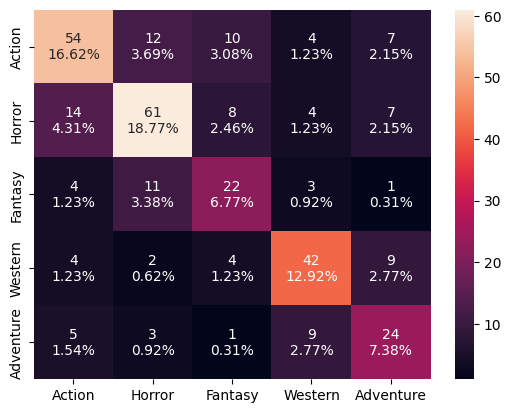

In [16]:
#Load saved model
model = Model(len(vocab), embedding_size=16,
              hidden_size=8, num_classes=len(categories))
model.to(device)
model.load_state_dict(torch.load('model_01'))

with torch.no_grad():
    outputs = torch.softmax(
        model(indexed_test_x, test_lens_x), dim=1).cpu().numpy().argmax(axis=1)

actual    = indexed_test_y.cpu()
prediction = outputs
    
cm = sklearn.metrics.confusion_matrix(actual, outputs)
count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
          zip(count,percentage)]).reshape(5,5)

sns.heatmap(cm,fmt='',annot=labels,
            xticklabels=cat2idx.keys(),yticklabels=cat2idx.keys())

#Generate Accuracy, Precision, Recall, F1 Score   
print('Accuracy:\t%.3f'%  sklearn.metrics.accuracy_score (prediction, actual))
print('Precision:\t%.3f'% sklearn.metrics.precision_score(prediction, actual, average='macro'))
print('Recall:  \t%.3f'%  sklearn.metrics.recall_score   (prediction, actual, average='macro'))
print('F1 Score:\t%.3f'%  sklearn.metrics.f1_score       (prediction, actual, average='macro'))
print()

Measure the F1 score performance of the model when applied on the test set.
Also plot a confusion matrix showing how often each genre is mistaken as another genre.

## Title generation (25%)

Now that you've proven that titles and genre are related, make a model that can generate a title given a genre.

Again, you need to generate tokens at the character level instead of the word level and the titles must be lowercased.
Preprocess the data sets, create a neural network, and train it to generate the movie titles given their genre.
Plot a graph of the **perplexity** of the model on the train and validation sets after each epoch.

In [75]:
# Get all titles
titles = df['title']

# Tokenise every character
titles = texts.apply(lambda s: [*s])

# Get One-Hot encoding of genres
categories = ['Action', 'Horror', 'Fantasy', 'Western', 'Adventure']
cat2idx = {cat: i for (i, cat) in enumerate(categories)}
genres = torch.tensor(df['genre'].map(cat2idx.get).to_numpy()[
                      :, None], dtype=torch.int64, device=device)
genres = torch.nn.functional.one_hot(
    genres[:, 0], num_classes=5).float()

# Get lenght of every title including the EDGE token
title_lens = torch.tensor([len(t)+1 for t in titles],
                          dtype=torch.int64, device=device)

# Get maximum length of a title
max_len = max(title_lens)

# Get vocabulary
vocab = ['<PAD>','<EDGE>'] + sorted({tok for t in titles for tok in t})

# Get train_x
padded_train_x = [['<EDGE>']+t+['<PAD>']
                  * (max_len-len(t)-1) for t in titles]
indexed_train_x = torch.tensor(
    [[vocab.index(tok) for tok in t] for t in padded_train_x],
    dtype=torch.int64, device=device)

# Get train_y
padded_train_y = [t+['<EDGE>']+['<PAD>']
                  * (max_len-len(t)- 1) for t in titles]
indexed_train_y = torch.tensor(
    [[vocab.index(tok) for tok in t] for t in padded_train_y],
    dtype=torch.int64, device=device)

Generate 3 titles for every genre.
Make sure that the titles are not all the same.

In [54]:
class Model(torch.nn.Module):

    def __init__(self, cond_size, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_size)
        
        self.rnn_s0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_c0 = torch.nn.Parameter(
            torch.zeros((hidden_size,), dtype=torch.float32))
        self.rnn_cell = torch.nn.LSTMCell(embedding_size, hidden_size)
        
        self.output_layer = torch.nn.Linear(cond_size+hidden_size, vocab_size)
        
        
    def forward(self, cond, x):
        batch_size = x.shape[0]
        time_steps = x.shape[1]
        
        embedded = self.embedding_layer(x)
        
        state = self.rnn_s0.unsqueeze(0).tile((batch_size,1))
        c = self.rnn_s0.unsqueeze(0).tile((batch_size,1)) #ERROR??
        interm_states = []
        
        #Get intermediate states
        for t in range(time_steps):
            (state,c) = self.rnn_cell(embedded[:,t,:], (state,c))
            interm_states.append(state)
        interm_states = torch.stack(interm_states, dim=1)
        
        #Replicate the same conditioning vector for every character
        cond_3d = cond.unsqueeze(1).tile((1, time_steps, 1))
        
        #Attach the replicated conditioning vector to the intermediate states
        interm_states = torch.cat((cond_3d, interm_states), dim=2)
        
        return self.output_layer(interm_states)

In [113]:
model = Model(genres.shape[1], len(vocab), embedding_size=16, hidden_size=8)
model.to(device)

optimiser = torch.optim.Adam(model.parameters())

print('step', 'error')
train_errors = []
batch_size = indexed_train_x.shape[0]
time_steps = indexed_train_x.shape[1]

mask = torch.zeros((batch_size, time_steps), dtype=torch.bool, device=device)
for i in range(batch_size):
    for j in range(time_steps):
        if j >= title_lens[i]:
            mask[i, j] = 1

for step in range(1, 20_000+1):
    optimiser.zero_grad()
    output = model(genres, indexed_train_x)
    errors = torch.nn.functional.cross_entropy(
        output.transpose(1, 2), indexed_train_y, reduction='none')
    errors = torch.masked_fill(errors, mask, 0.0)
    error = errors.sum()/title_lens.sum()
    train_errors.append(error.detach().tolist())
    error.backward()
    optimiser.step()
    
    print(step, end='\r')
    
    if step % 2_000 == 0:
        print(step, train_errors[-1])
print()
    

step error
2000 2.3993618488311768
4000 2.299030303955078
6000 2.2663774490356445
8000 2.251842737197876
10000 2.2452456951141357
12000 2.2418689727783203
14000 2.2395639419555664
16000 2.2376904487609863
18000 2.236069440841675
20000 2.2350869178771973



In [120]:
name_genre = [('Action',   [0,0,0,0,0]),
              ('Horror',   [0,0,0,0,1]),
              ('Fantasy',  [0,0,0,1,0]),
              ('Western',  [0,0,1,0,0]),
              ('Adventure',[0,1,0,0,0]),
             ]
with torch.no_grad():
    for (name, genre) in name_genre:
        
        genre = torch.tensor([genre], dtype=torch.float32, device=device)
        prefix_indexes = [vocab.index('<EDGE>')]
        
        #Start generating words
        max_characters = 20
        for _ in range(max_characters):
            
            prefix_tensor = torch.tensor(
                [prefix_indexes], dtype=torch.int64, device=device)
            
            outputs = torch.softmax(model(genre, prefix_tensor), dim=2)
            
            word_probs = outputs[0, -1, :].tolist()
            
            next_word_index = random.choices(range(len(vocab)), word_probs)[0]
            
            #Stop when <EDGE> token is encountered
            if next_word_index == vocab.index('<EDGE>'):
                break
            
            prefix_indexes.append(next_word_index)
            
            
        sent = [vocab[index] for index in prefix_indexes[1:]]
        print(f"{name}: {''.join(sent)}")
        print()

Action: the prighesm/hix 4: 

Horror: the sagent qoaocuriu

Fantasy: the loven

Western: tilycolhtiri

Adventure: bape



## Language models as classifiers (30%)

It occurs to you that the movie title generator can also be used as a classifier by doing the following:

* Let title $t$ be the title that you want to classify.
* For every genre $g$,
    * Use the generator as a language model to get the probability of $t$ (the whole title) using genre $g$.
* Pick the genre that makes the language model give the largest probability.

The producer is thrilled to not need two separate models and now you have to implement this.
**Use the preprocessed test set from the previous task** in order to find the genre that makes the language model give the largest probability.
There is no need to plot anything here.

Just like in the classification task, measure the F1 score and plot the confusion matrix of this new classifier.

Write a paragraph or psuedo code to describe what your code above does.

In [ ]:
'''

'''

## Conclusion (10%)

The producer's funders are asking for a report about this new technology they invested in.
In 300 words, write your interpretation of the results together with what you think could make the model perform better.

In [ ]:
'''

'''